In [ ]:
##!/usr/bin/env python
"""plot_cmip_skill.py

This script compares the heatwave diagnostics of CMIP6 to Berkeley Earth

Using the Excess Heat Factor 
Baseline Period: 1950-2014, 90th Percentile Threshold

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Wed Nov 11 10:54:39 AEDT 2020

"""

### Load Python Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#from __future__ import division
import numpy as np
import netCDF4 as nc
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
#import common_functions as cf
import cartopy.crs as ccrs
import xesmf as xe
from scipy import stats
from scipy import signal
import math
import regionmask

### Updated IPCC regions

This is a python package containing the new regions: import regionmask

Iturbide, M., Guti�errez, J.M., Alves, L.M., Bedia, J., Cimadevilla, E., Cofi~no, A.S., Cerezo-Mota, R., Di Luca, A., Faria, S.H., Gorodetskaya, I., Hauser, M., Herrera, S., Hewitt, H.T., Hennessy, K.J., Jones, R.G., Krakovska, S., Manzanas, R., Marínez-Castro, D., Narisma, G.T., Nurhati, I.S., Pinto, I., Seneviratne, S.I., van den Hurk, B., Vera, C.S., 2020. An update of IPCC climate reference regions for subcontinental analysis of climate model data: definition and aggregated datasets. Earth Syst. Sci. Data Discuss. https://doi.org/10.5194/essd-2019-258

Git repo with the new regions: https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-regions

In [3]:
rlabels = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS',
                  'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED',
                  'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'RAR', 'WSB',
                  'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA', 'NAU',
                  'CAU', 'EAU', 'SAU', 'NZ']#, 'EAN', 'WAN']
nreg = len(rlabels)

ar6_land = regionmask.defined_regions.ar6.land

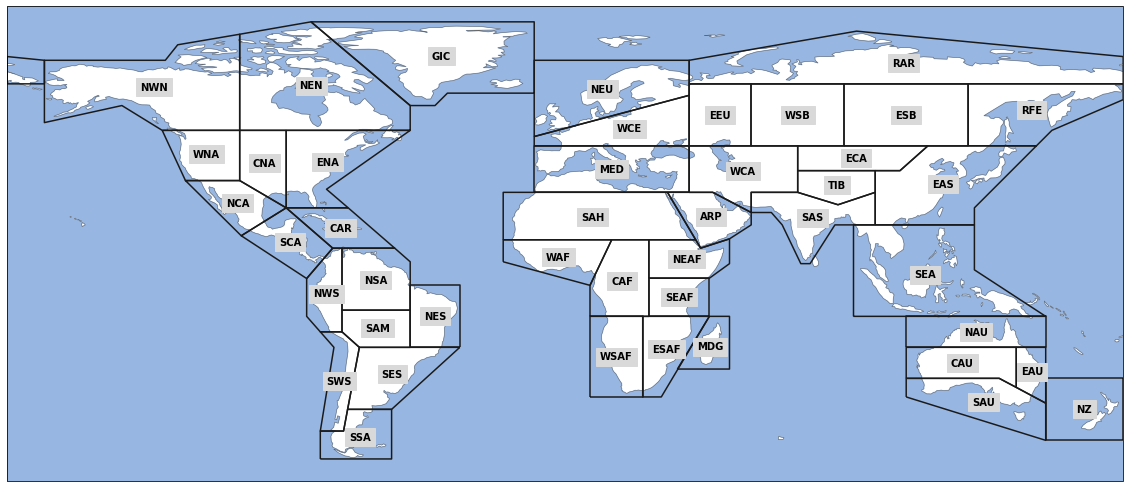

In [13]:
projection = ccrs.PlateCarree(central_longitude=0)
plt.rcParams['savefig.dpi']=500
plt.rcParams["font.weight"] = "bold"
fig, ax = plt.subplots(1,1,figsize=(20,30), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
ax = ar6_land[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43]].plot(proj=projection, label="abbrev", add_ocean=True)
plt.savefig('ar6_climate_reference_regions.png')

### Berkeley Earth

This data has nlat = 180, nlon = 360 so it is 1deg data

In [4]:
berkdir = '/g/data/w97/azh561/cmip_heatwave/BerkleyEarth/'

# Define the filename convention:
bprefix = 'EHF_'
bendfix = '_summer_BerkleyEarth_1950-2014.nc'

# for the cumulative heat
ehifile = 'BerkleyEarth_HW_daily_EHI_value_1950_2017_bp_1950_2014.nc'
spellfile = 'BerkleyEarth_HW_daily_EHF_1950_2017_bp_1950_2014.nc'

### CMIP6 data

Note that in this instance we start with the first ensemble member 'r1i1p1f1' for all models

They are all on different resolutions! So will require regridding to plot and evaluate:

    - finest resolution: nlat = 256, nlon = 512 -> 0.7 deg x 0.7 deg
    - coarsest resolution: nlat = 96, nlon = 144 -> 1.875 deg x 2.5 deg

In [5]:
cmip6dir = '/g/data/w97/azh561/cmip_heatwave/cmip6_ehf/'

# Define the models
models = ['ACCESS-CM2','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1','CanESM5','CMCC-CM2-SR5',
'EC-Earth3-AerChem','EC-Earth3','EC-Earth3-Veg','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4',
'GFDL-ESM4','GISS-E2-1-G','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC6',
'MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorCPM1','NorESM2-LM','NorESM2-MM','TaiESM1']
nmod = len(models)

# Define the filename convention:
mprefix = 'EHF_heatwaves_'
mendfix = '_historical_r1i1p1f1_yearly_summer.nc'

# The EHI files
ehipfix = 'EHI_heatwaves_'
ehfpfix = 'EHF_heatwaves_'
ehiefix = '_historical_r1i1p1f1_daily.nc'

### CMIP5 data

Note that in this instance we start with the first ensemble member 'r1i1p1' for all models


In [6]:
cmip5dir = '/g/data/w97/azh561/cmip_heatwave/cmip5_ehf/'

# Define the models
models = ['ACCESS1-0','ACCESS1.3','bcc-csm1-1','bcc-csm1-1-m','BNU-ESM',
          'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CESM',
'CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0','FGOALS_g2','GFDL-CM3',
'GFDL-ESM2G','GFDL-ESM2M',#'HadGEM2-AO','HadGEM2-CC','HadGEM2-ES',
          'inmcm4',
'IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR','MIROC5','MIROC-ESM-CHEM',
'MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','MRI-ESM1','NorESM1-M']

nmod = len(models)

# Define the filename convention:
mprefix = 'EHF_heatwaves_'
mendfix = '_historical_r1i1p1_yearly_summer.nc'

# The EHI files
ehipfix = 'EHI_heatwaves_'
ehfpfix = 'EHF_heatwaves_'
ehiefix = '_historical_r1i1p1_daily.nc'


### Calculation Functions Used in this notebook

In [7]:
# Function to create plot
def calc_ts_trend(data,thres=None):
    """This function utilises existing functions to calculate the trend of a time series.
    Note that missing data is removed from the time series.
    
    Inputs:
        data == 1D time series
        thres (optional) = the threshold for minimum data availability
    """
    
    import math
    from scipy import stats
    
    # If a threshold is not defined use a default
    if not thres:
        thres = 0.5
    
    # Create the dummy array for the 'time' instances
    xx = np.arange(1,len(data)+1)
    
    # Calculate the minimum no. of data points
    npts = math.floor(len(data) * thres)
        
    # Use data[~np.isnan(data)] to screen for missing values in the observations
    # Apply constraint that there needs to be atleast 70% of the data
    if len(data[~np.isnan(data)]) >= npts:
        theilslope = stats.theilslopes(data[~np.isnan(data)],x=xx[~np.isnan(data)], alpha = 0.90)
        slope = theilslope[0]
        if theilslope[2] <= 0.0 <= theilslope[3]: # If the confidence interval contains zero the trend is not significant
            sig = 0.0 
        else:
            sig = 1.0
        del theilslope
    else:
        slope = np.nan
        sig = np.nan

    return slope,sig

In [8]:
def sig_fdr(mask,obs,mod=None):
    """This function calculates the statistical significance and accounts for field significance according
    to Wilks 2016"""
    
    # Calculate the p-values
    if mod is not None:
        # t-test on 2 independent samples and assume non-equal variance
        _,pval = stats.ttest_ind(obs, mod, axis=0, equal_var=False, nan_policy='omit')
    else:
         # t-test on 2 independent samples and assume non-equal variance
        _,pval = stats.ttest_1samp(obs, 0.0, axis=0, nan_policy='omit')

    # Define the significance level
    afdr = 0.2
    
    # Determine the number of points
    N = np.count_nonzero(~np.isnan(mask2d.values))
    
    # Rank the p-values and reshape to 1D
    pvalma = np.where(mask2d==0, pval,np.nan)
    pval1d = np.reshape(pvalma,-1)
    pval_sorted = np.sort(pval1d[~np.isnan(pval1d)])
    
    # Calculate the FDR p-value
    if [i for count,i in enumerate(pval_sorted) if i<=afdr*(count+1)/float(len(pval_sorted))] == []:
        p_fdr =0
    else:
        p_fdr = max([i for count,i in enumerate(pval_sorted) if i<=afdr*(count+1)/float(len(pval_sorted))])

    # Determine if the actual p values are less than the FDR p-value
    sig = np.where(pvalma<p_fdr,1,0)
    
    return sig

In [9]:
def hwseason(data,spell,yr,variable):
    
    # Define the output array
    dataout = np.empty((len(data['lat'].values),len(data['lon'].values)),dtype=np.float64)

    # Select relevant data, mask for non-HW days and sum across the Northern Hemisphere MJJAS
    nhtmp = data[variable].loc['%s-05-01' %(yr):'%s-09-30' %(yr),:,:]
    nhspell = spell['event'].loc['%s-05-01' %(yr):'%s-09-30' %(yr),:,:]
    nhma = np.ma.masked_array(nhtmp,nhspell<=0).filled(np.nan)

    dataout[90:,:] = np.nansum(nhma[:,90:,:],axis=0)
    del nhtmp,nhspell,nhma
    
    # Select relevant data, mask for non-HW days and sum across the Southern Hemisphere NDJFM
    shtmp1 = data[variable].loc['%s-11-01' %(yr):'%s-12-31' %(yr),:,:]
    shspell1 = spell['event'].loc['%s-11-01' %(yr):'%s-12-31' %(yr),:,:]
    shma1 = np.ma.masked_array(shtmp1,shspell1<=0).filled(np.nan)

    if yr == 2014:
        dataout[:90,:] = np.nansum(shma1[:,:90,:],axis=0)
    else:
        shtmp2 = data[variable].loc['%s-01-01' %(yr+1):'%s-03-31' %(yr+1),:,:]
        shspell2 = spell['event'].loc['%s-01-01' %(yr+1):'%s-03-31' %(yr+1),:,:]
        shma2 = np.ma.masked_array(shtmp2,shspell2<=0).filled(np.nan)
        dataout[:90,:] = np.nansum(shma1[:,:90,:],axis=0) + np.nansum(shma2[:,:90,:],axis=0)
        del shtmp2,shspell2,shma2
    del shtmp1,shspell1,shma1
    
    return dataout

### Plotting Functions

#### For Contour Plots

In [10]:
def plot_ensemble_contour(lat1d,lon1d,odata,osig,data6,datasig6,data5,datasig5,vlabel,omn,omx,mnmx,rmnmx,figurename,trendflag=True):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib import colors
    from matplotlib import cm
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import cartopy.crs as ccrs
    from string import ascii_lowercase
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=300
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    # Set up projection
    plotcrs = ccrs.PlateCarree(central_longitude=0)
    lon2d, lat2d = np.meshgrid(lon1d, lat1d)
    
    nrow = 4
    ncol = 3
    nvar = odata.shape[0]
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=((5.5*ncol),2*nrow), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

    # Define the colormaps
    if trendflag == True:
        ocmap = plt.get_cmap('seismic')
        ocmap.set_bad('w')
    else:
        ocmap = plt.get_cmap('YlOrRd')
        ocmap.set_bad('w')
        
    cmap = plt.get_cmap('seismic')
    cmap.set_bad('w')        
    # Loop through the diagnostics
    vind = 0
    for vv in range(nvar):       
        
        # Berkeley Earth
        cm = ax[vv,0].contourf(lon2d,lat2d,odata[vv,:,:],vmin=omn[vv],vmax=omx[vv],cmap=ocmap, 
                               levels=MaxNLocator(nbins=10).tick_values(omn[vv],omx[vv]), 
                               norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(omn[vv],omx[vv]), ncolors=ocmap.N, clip=True), extend='both',transform=ccrs.PlateCarree())
        ax[vv,0].coastlines()
        ax[vv,0].text(0.016,0.035,'(%s)' %(ascii_lowercase[vind]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[vv,0].transAxes,fontweight='bold', fontsize=14)
        ax[vv,0].contourf(lon2d,lat2d,osig[vv,:,:],1,colors="none",hatches=[None,'xx'],extend='lower',transform=ccrs.PlateCarree())
        ax[vv,0].text(-0.05,0.5,vlabel[vv],horizontalalignment='center',verticalalignment='center',transform = ax[vv,0].transAxes,rotation=90.,fontweight='bold', fontsize=10)
        plt.colorbar(cm, ax=ax[vv,0])
        vind += 1
        
        # CMIP6 Ensemble Mean
        ce6 = ax[vv,1].contourf(lon2d,lat2d,data6[vv,:,:],vmin=-mnmx[vv],vmax=mnmx[vv],cmap=cmap, 
                               levels=MaxNLocator(nbins=20).tick_values(-mnmx[vv],mnmx[vv]), 
                               norm=BoundaryNorm(MaxNLocator(nbins=20).tick_values(-mnmx[vv],mnmx[vv]), ncolors=cmap.N, clip=True), extend='both',transform=ccrs.PlateCarree())
        ax[vv,1].coastlines()
        ax[vv,1].text(0.016,0.035,'(%s)' %(ascii_lowercase[vind]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[vv,1].transAxes,fontweight='bold', fontsize=14)
        ax[vv,1].contourf(lon2d,lat2d,datasig6[vv,:,:],1,colors="none",hatches=[None,'xx'],extend='lower',transform=ccrs.PlateCarree())
        plt.colorbar(ce6, ax=ax[vv,1])
        vind += 1
        
        # CMIP5 Ensemble Mean
        ce5 = ax[vv,2].contourf(lon2d,lat2d,data5[vv,:,:],vmin=-mnmx[vv],vmax=mnmx[vv],cmap=cmap, 
                               levels=MaxNLocator(nbins=20).tick_values(-mnmx[vv],mnmx[vv]), 
                               norm=BoundaryNorm(MaxNLocator(nbins=20).tick_values(-mnmx[vv],mnmx[vv]), ncolors=cmap.N, clip=True), extend='both',transform=ccrs.PlateCarree())
        ax[vv,2].coastlines()
        ax[vv,2].text(0.016,0.035,'(%s)' %(ascii_lowercase[vind]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[vv,2].transAxes,fontweight='bold', fontsize=14)
        ax[vv,2].contourf(lon2d,lat2d,datasig5[vv,:,:],1,colors="none",hatches=[None,'xx'],extend='lower',transform=ccrs.PlateCarree())
        plt.colorbar(ce5, ax=ax[vv,2])
        vind += 1
           
        if vv == 0:
            ax[0,0].set_title('Berkeley Earth', fontweight='bold', fontsize=14)
            ax[0,1].set_title('CMIP6 Ensemble - Berkeley Earth', fontweight='bold', fontsize=14)
            ax[0,2].set_title('CMIP5 Ensemble - Berkeley Earth', fontweight='bold', fontsize=14)


    fig.tight_layout()
    fig.subplots_adjust(wspace=0.0001, hspace=0.025)

    plt.savefig(figurename, bbox_inches='tight')
#    plt.close(fig)


#### For Boxplots

In [32]:
# Function to create plot
def plot_boxplot(odata,data6,data5,vlabel,rlabel,mn,mx,figurename):
    """This function plots boxplots for each of the regions.
    """

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib.colors import LinearSegmentedColormap
    from string import ascii_lowercase

    # Retrieve dimensions
    nvar = data6.shape[0]
    nreg = data6.shape[1]
        
    # Create figure object and subplots
    plt.rcParams['savefig.dpi'] = 500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    mycolors = ["black","black","black","black"]
    
    # Create figure object and subplots
    
    fig, ax = plt.subplots(nrows=nvar,ncols=nreg, figsize=((4*nvar),10.),sharex=False, sharey=False)

    # Plot data as a box plot
    counter = 0
    for vv in range(nvar):
        for rr in range(nreg):
            
            # CMIP6
            bp6 = ax[vv,rr].boxplot(data6[vv,rr,:], 1, 'k+', positions=[0.25], patch_artist=False, widths = 0.375)
            plt.setp(bp6['boxes'], color='black', linewidth=2)
            plt.setp(bp6['whiskers'], color='black', linewidth=2)
            plt.setp(bp6['caps'], color='black', linewidth=2)
            plt.setp(bp6['medians'], color='black', linewidth=1)
            
            # CMIP5
            bp5 = ax[vv,rr].boxplot(data5[vv,rr,:], 1, 'rx', positions=[0.75], patch_artist=False, widths = 0.375)
            plt.setp(bp5['boxes'], color='red', linewidth=2)
            plt.setp(bp5['whiskers'], color='red', linewidth=2)
            plt.setp(bp5['caps'], color='red', linewidth=2)
            plt.setp(bp5['medians'], color='red', linewidth=1)
            
            ax[vv,rr].set_xticks([])
            
            # Add the observations to the boxplot
            ax[vv,rr].plot(0.5,odata[vv,rr],'b*',markersize=10) 
            
            # Amend Y-axes
            ax[vv,rr].set_ylim(mn[vv],mx[vv])
            if rr == 0:
                ax[vv,rr].set_ylabel(vlabel[vv], fontsize=12)
                ax[vv,rr].text(0.05,0.01,'(%s)' %(ascii_lowercase[vv]),horizontalalignment='left',verticalalignment='bottom',transform = ax[vv,rr].transAxes,fontweight='bold', fontsize=12)
                ax[vv,rr].spines['right'].set_visible(False)
            else:
                ax[vv,rr].set_yticks([])
                ax[vv,rr].spines['right'].set_visible(False)
                ax[vv,rr].spines['left'].set_visible(False)
            if rr == nreg-1:
                ax[vv,rr].spines['right'].set_visible(True)

            # To delineate the continental regions
            if rr in [8,15,19,27,31,38]:#,43]:
                ax[vv,rr].spines['right'].set_visible(True)
                plt.setp(ax[vv,rr].spines['right'], color='grey', linewidth=2, linestyle='--')
           
        
            # Add text to label continental regions
            continentlb = ['Nth. America',"Sth. America","Europe","Africa","Russia","Asia","Oceania","Ant."]
            if rr in [7,15,19,25,31,36,43,45] and vv == 0:
                if rr == 45:
                    xpos = 0.9
                elif rr == 19:
                    xpos = 0.5
                else:
                    xpos = 0.1875
                ax[vv,rr].text(xpos,1.05,continentlb[counter], horizontalalignment='right',
                    verticalalignment='center',transform = ax[vv,rr].transAxes,color='black', fontweight='bold', fontsize=14)
                counter += 1
                
            # Add region labels on X-axes
            if vv == nvar-1:
                ax[vv,rr].text(0.5,-0.35,rlabel[rr],horizontalalignment='center',verticalalignment='bottom',transform = ax[vv,rr].transAxes,rotation=90.,fontweight='bold', fontsize=14)

    # Finalise the figure layout
    
    fig.tight_layout()   
    fig.subplots_adjust(wspace=0, hspace=0.1)

    fig.savefig(figurename,bbox_inches = "tight")
#    plt.close(fig)


#### For Skill Plots

In [12]:
# Function to create triangles for the contour plot
def getCustomSymbol1(path_index=1):
    if path_index==1:   #left triangle
        verts = [
        (0.0,0.0),
        (0.0,1.0),
        (0.5,0.5),
        (0.0,0.0),]
    elif path_index==2: # bottom triangle
        verts = [
        (0.0,0.0),
        (1.0,0.0),
        (0.5,0.5),
        (0.0,0.0),]
    elif path_index==3: # right triangle
        verts = [
        (1.0,0.0),
        (1.0,1.0),
        (0.5,0.5),
        (1.0,0.0),]
    elif path_index==4: # top triangle
        verts = [
        (0.0,1.0),
        (1.0,1.0),
        (0.5,0.5),
        (0.0,1.0),]
    codes = [mpl.path.Path.MOVETO,
           mpl.path.Path.LINETO,
           mpl.path.Path.LINETO,
           mpl.path.Path.CLOSEPOLY,
           ] 
    pathCS1 = mpl.path.Path(verts, codes)
    return pathCS1, verts

In [13]:
# Function to create plot
def plot_ALLSKILL(diag,RCMlabels,figurename,vlabels,mtitle,mx=None,mn=None):
    """This function plots model skill in the context of observational uncertainty.
    
    Input arguments: 
        scores - multi-dimensional array containing the skill scores
        RCMlabels - list containing model/experiment names
        figurename - file name for saving the figure to
        vlabels - array containing the variables included
        Rname - region names
        mtitle - main title
        mx = max value on colorbar
        mn = min value on colorbar
    """

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib.colors import LinearSegmentedColormap

    # Retrieve dimensions
    nreg = diag.shape[1] # Regions
    nmod = diag.shape[2] # Models
        
    # Create figure object and subplots
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    # Create figure object and subplots
    nrow=1
    ncol=2

    gs = mpl.gridspec.GridSpec(nrow,ncol, width_ratios=[2.,0.1], wspace=0.05)
    fig = plt.figure(figsize=(16,16))

    # Make axes
    ax = fig.add_subplot(gs[0,0])

    # Colour bar axes (':' as the colour bars cover multiple rows)
    # Use a new subplot so we can control the spacing better
    cgs = mpl.gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[:,-1], wspace=2)
    cax = plt.subplot(cgs[0,0]) 

    if not mx:
        mx=1.
    if not mn:
        mn=0.
    
    # Define the colormap - using a 'traffic light' approach
    nbins=20    
    cmap = plt.get_cmap('PiYG')
    cmap.set_bad('w')
    levels = MaxNLocator(nbins=nbins).tick_values(mn,mx)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    


    # Plot all diagnostics as triangles
    
    nx,ny = nmod,nreg

    shift = 0.0
    
    # diag1 is the top triangle
    X,Y,tval = zip(*[ (0.5+i/2.,j+0.5,diag[0,i,j]) for i in range(ny) for j in range(nx) ] )  
    tmarker,tverts = getCustomSymbol1(path_index=4)    
    ax.scatter(Y,X,s=900,marker=tmarker,c=tval,cmap=cmap,vmin=mn,vmax=mx,norm=norm,edgecolor='black')

    # diag2 is the bottom triangle
    X,Y,bval = zip(*[ (0.5+i/2.,j+0.5,diag[1,i,j]) for i in range(ny) for j in range(nx) ] )
    bmarker,bverts = getCustomSymbol1(path_index=2)    
    ax.scatter(Y,X,s=900,marker=bmarker,c=bval,cmap=cmap,vmin=mn,vmax=mx,norm=norm,edgecolor='black')

    # diag3 is the left triangle
    X,Y,lval = zip(*[ (0.5+i/2.,j+0.5,diag[2,i,j]) for i in range(ny) for j in range(nx) ] )
    lmarker,lverts = getCustomSymbol1(path_index=1)    
    ax.scatter(Y,X,s=900,marker=lmarker,c=lval,cmap=cmap,vmin=mn,vmax=mx,norm=norm,edgecolor='black')

    # diag4 is the right triangle
    X,Y,rval = zip(*[ (0.5+i/2.,j+0.5,diag[3,i,j]) for i in range(ny) for j in range(nx) ] )
    rmarker,rverts = getCustomSymbol1(path_index=3)    
    ax.scatter(Y,X,s=900,marker=rmarker,c=rval,cmap=cmap,vmin=mn,vmax=mx,norm=norm,edgecolor='black')
    
    # Specify Figure Axes
    
    xarr = np.arange(min(Y),max(Y)+1.5,0.5)
    xticks = np.arange(min(Y)+0.25,max(Y)+1.25,1)
    
    yarr = np.arange(min(X),max(X)+0.5,0.25)
    yticks = np.arange(min(X)+0.25,max(X)+0.75,0.5)

    ax.set_yticklabels(vlabels[::-1],ha='right')
    ax.set_yticks(yticks)
    ax.set_ylim(yarr[0]-0.25,yarr[-1]+0.5)
    ax.set_xlim(xarr[0]-0.5,xarr[-1])
    ax.set_xticklabels(RCMlabels, fontsize = 10, rotation = 90.)
    ax.set_xticks(xticks)

    ax.set_title('%s' %(mtitle), fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A=[]
    fig.colorbar(sm,cax,ticks=levels[::2])

    # Add text/legend to plot
    
    ax.text(1.065,-0.025,'HWF',horizontalalignment='center',verticalalignment='top',transform = ax.transAxes,fontweight='bold', fontsize=14)
    ax.text(1.01,-0.1,'HWM',horizontalalignment='center',verticalalignment='bottom',transform = ax.transAxes,rotation=90.,fontweight='bold', fontsize=14)
    ax.text(1.065,-0.11,'HWD',horizontalalignment='center',verticalalignment='top',transform = ax.transAxes,fontweight='bold', fontsize=14)
    ax.text(1.115,-0.1,'HWC',horizontalalignment='center',verticalalignment='bottom',transform = ax.transAxes,rotation=270.,fontweight='bold', fontsize=14)

#    ll = ax.plot(max(X)+11.5,min(Y)-2.0,'kx',markersize=55) # For CMIP6
    ll = ax.plot(max(X)+10.5,min(Y)-2.0,'kx',markersize=55) # For CMIP5
    ll[0].set_clip_on(False) 

#    ll = ax.plot(max(X)+11.5,min(Y)-2.0,'ks',markersize=55, mfc='none') # For CMIP6
    ll = ax.plot(max(X)+10.5,min(Y)-2.0,'ks',markersize=55, mfc='none') # For CMIP5
    ll[0].set_clip_on(False) 
    
    # Finalise the figure layout
    
    fig.tight_layout()   
    fig.subplots_adjust(wspace=0, hspace=0, left=0.25)

    fig.savefig(figurename,bbox_inches = "tight")
#    plt.close(fig)


#### For Histograms

In [14]:
# Function to create plot
def plot_hist(data6,data5,modlb6,modlb5,vlabel,figurename):
    """This function plots histograms for CMIP5 and CMIP6 of the global spatial distribution skill score.
    """

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib.colors import LinearSegmentedColormap
    from string import ascii_lowercase

    # Retrieve dimensions
    nvar = data6.shape[0]
    nmod = data6.shape[1]
    nmod5 = data5.shape[1]
        
    # Create figure object and subplots
    plt.rcParams['savefig.dpi'] = 500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    mycolors = ["black","black","black","black"]
    
    # Create figure object and subplots
    
    fig, ax = plt.subplots(nrows=nvar,ncols=2, figsize=(10.,10.))

    # CMIP 6
    nmind6 = np.argsort(data6[1,:])
    mlb6 = []
    for mm in range(nmod):
        mlb6.append(modlb6[nmind6[mm]])
    ax[0,0].bar(np.arange(1,nmod+1),data6[1,nmind6], 1.0, color="blue",edgecolor='black')
    ax[0,0].set_xlim(0.5,nmod+0.5) 
    ax[0,0].set_xticks(np.arange(1,nmod+1))
    ax[0,0].set_xticklabels(mlb6,rotation=90,fontsize=10)
    ax[0,0].set_title('(a) CMIP6 %s' %(vlabel[1]), fontweight='bold')
    ax[0,0].set_ylabel('Spatial Distribution Skill Score', fontweight = 'bold',fontsize=14)
    ax[0,0].set_yticks(np.arange(0.0,1.2,0.2)) 

    
    nmind6 = np.argsort(data6[0,:])
    mlb6 = []
    for mm in range(nmod):
        mlb6.append(modlb6[nmind6[mm]])
    ax[1,0].bar(np.arange(1,nmod+1),data6[0,nmind6], 1.0, color="blue",edgecolor='black')
    ax[1,0].set_xlim(0.5,nmod+0.5) 
    ax[1,0].set_xticks(np.arange(1,nmod+1))
    ax[1,0].set_xticklabels(mlb6,rotation=90,fontsize=10)
    ax[1,0].set_title('(c) CMIP6 %s' %(vlabel[0]), fontweight='bold')
    ax[1,0].set_ylabel('Spatial Distribution Skill Score', fontweight = 'bold',fontsize=14)
    ax[1,0].set_yticks(np.arange(0.0,1.2,0.2)) 
    
    # CMIP 5
    nmind5 = np.argsort(data5[1,:])
    mlb5 = []
    for mm in range(nmod5):
        mlb5.append(modlb5[nmind5[mm]])
    ax[0,1].bar(np.arange(1,nmod5+1),data5[1,nmind5], 1.0, color="blue",edgecolor='black')
    ax[0,1].set_xlim(0.5,nmod5+0.5) 
    ax[0,1].set_xticks(np.arange(1,nmod5+1))
    ax[0,1].set_xticklabels(mlb5,rotation=90,fontsize=10)
    ax[0,1].set_title('(b) CMIP5 %s' %(vlabel[1]), fontweight='bold')
    ax[0,1].set_yticks([],[]) 
    ax[0,1].set_ylabel('')

        
    nmind5 = np.argsort(data5[0,:])
    mlb5 = []
    for mm in range(nmod5):
        mlb5.append(modlb5[nmind5[mm]])
    ax[1,1].bar(np.arange(1,nmod5+1),data5[0,nmind5], 1.0, color="blue",edgecolor='black')
    ax[1,1].set_xlim(0.5,nmod5+0.5) 
    ax[1,1].set_xticks(np.arange(1,nmod5+1))
    ax[1,1].set_xticklabels(mlb5,rotation=90,fontsize=10)
    ax[1,1].set_title('(d) CMIP5 %s' %(vlabel[0]), fontweight='bold')
    ax[1,1].set_ylabel('')
    ax[1,1].set_yticks([],[]) 
    
    for aa in ax.reshape(-1): 
        aa.set_ylim(0.0,1.0)
        aa.axhline(y=0.5, color='r', linestyle='--')
        aa.axhline(y=0.2, color='r', linestyle='--')

    # Finalise the figure layout    
    fig.tight_layout()
    fig.savefig(figurename,bbox_inches = "tight")
#    plt.close(fig)


## CMIP ensemble figures

Note that here we focus on a subset of the variables including HWF, HWD, HWM and HWC

In [3]:
# Define the summer statistics of interest / variable names in the netcdf files
var = ['HWF','HWD','HWM','HWC']
nvar = len(var)
omn = [10,0,0,0] # minima for the observed mean
omx = [20,10,10,20] # maxima for the observed mean
otmx = [5,2,1,5] # maxima for the observed trend
notmx = [-5,-2,-1,-5] # minima for the observed trend
varlim = [20,10,20,20] # bias limits
trendlim = [5.,2.,2.,5.] # trend limits

# Define the summer statistics of interest / variable names in the netcdf files
modvar = ['HWF_EHF','HWD_EHF','HWM_EHF','HWC_EHF']

Specify arrays to stash the diagnostics in

In [ ]:
nyrs = 65
nlat = 180
nlon = 360
sigpoint = math.ceil(nmod * 0.8) #80% of the models agree on the sign of the bias

berkmean = np.empty((4,nlat,nlon),dtype=np.float64)
berkslope = np.empty((4,nlat,nlon),dtype=np.float64)
berkslopesig = np.empty((4,nlat,nlon),dtype=np.float64)

ensbias = np.empty((4,nlat,nlon),dtype=np.float64)
ensbiasrange = np.empty((4,nlat,nlon),dtype=np.float64)
ensbiassign = np.zeros((4,nlat,nlon),dtype=np.float64) # 80% of the models agree on the sign of the bias
ensslope = np.empty((4,nlat,nlon),dtype=np.float64)
enssloperange = np.empty((4,nlat,nlon),dtype=np.float64)
ensslopesign = np.zeros((4,nlat,nlon),dtype=np.float64) # 80% of the models agree on the sign of the trend

skill = np.empty((4,nreg,nmod),dtype=np.float64)

berkregmean = np.empty((4,nreg),dtype=np.float64)
modregmean = np.empty((4,nreg,nmod),dtype=np.float64)

berkregtrend = np.empty((4,nreg),dtype=np.float64)
modregtrend = np.empty((4,nreg,nmod),dtype=np.float64)



Loop through the diagnostics

In [ ]:
for eind in range(nvar):
    
    print('Calculating and plotting %s' %(var[eind]))
    
    # TO DO If HWC need to do things slightly differentl!
    if var[eind] in ['HWC']:
        
        # Read in the Berkeley Earth data 
        berk = xr.open_dataset('%s%s' %(berkdir,ehifile))
        lat1d = berk['lat'].values
        lon1d = berk['lon'].values
        berkma = np.empty((nyrs,nlat,nlon),dtype=np.float64)

        bespell = xr.open_dataset('%s%s' %(berkdir,spellfile))

        yr=1950
        for yy in range(nyrs):

            berkma[yy,:,:] = hwseason(berk,bespell,yr,'EHIsig')
            yr +=1

        # Define the common grid for the models to regrid too!
        ds_out = xr.Dataset({'lat': (['lat'], berk['lat'].values),
                 'lon': (['lon'], berk['lon'].values),
                })

        del berk,bespell
        berkma[-1,:,:] = np.nan # Make the last year nan as model data for last summer season in the Southern Hemisphere is incomplete
        
        # Define an array to stash the model data and the skill metrics
        moddata = np.empty((nmod,nyrs,nlat,nlon),dtype=np.float64)

        # Now loop through the models
        # Read in the data and regrid
        for mind in range(nmod):
            dm = xr.open_dataset('%s%s%s%s' %(cmip6dir,ehipfix,models[mind],ehiefix))
            dms = xr.open_dataset('%s%s%s%s' %(cmip6dir,ehfpfix,models[mind],ehiefix))
            # If longitudes are 0 to 360 need to shift to -180 to 180
            # https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
            if np.nanmax(dm['lon']) > 200.:
                lon_name = 'lon'
                dm['_longitude_adjusted'] = xr.where(dm[lon_name] > 180,dm[lon_name] - 360,dm[lon_name])
                # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
                dm = (
                    dm
                    .swap_dims({lon_name: '_longitude_adjusted'})
                    .sel(**{'_longitude_adjusted': sorted(dm._longitude_adjusted)})
                    .drop(lon_name))
                dm = dm.rename({'_longitude_adjusted': lon_name})

            if np.nanmax(dms['lon']) > 200.:
                lon_name = 'lon'
                dms['_longitude_adjusted'] = xr.where(dms[lon_name] > 180,dms[lon_name] - 360,dms[lon_name])
                # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
                dms = (
                    dms
                    .swap_dims({lon_name: '_longitude_adjusted'})
                    .sel(**{'_longitude_adjusted': sorted(dms._longitude_adjusted)})
                    .drop(lon_name))
                dms = dms.rename({'_longitude_adjusted': lon_name})

            datahwseason = np.empty((nyrs,len(dm['lat'].values),len(dm['lon'].values)),dtype=np.float64)
            yr=1950
            for yy in range(nyrs):
                datahwseason[yy,:,:] = hwseason(dm,dms,yr,'EHIsig')
                yr += 1

            dm_new = xr.Dataset({
                'HWC': xr.DataArray(
                        data   = datahwseason,
                        dims   = ['year','lat','lon'],
                        coords = {'year': np.arange(1950,2015),'lat': dm['lat'].values,'lon': dm['lon'].values},
                        )
                    })
            datavalue = dm_new['HWC']
#            regridder = xe.Regridder(dm_new, ds_out, 'bilinear',reuse_weights=True)
            regridder = xe.Regridder(dm_new, ds_out, 'bilinear')
            moddata[mind,:,:,:] = regridder(datavalue)
            del dm,dms,dm_new,datavalue,regridder,datahwseason
        moddata[:,-1,:,:] = np.nan
        
    else:
        
        # Read in the Berkeley Earth data - decode times necessary as HWF and HWD in units of days
        berk = xr.open_dataset('%s%s%s%s' %(berkdir,bprefix,var[eind],bendfix),decode_times=False)
        berkma = np.ma.masked_array(berk[var[eind]].values,berk[var[eind]].values<=0).filled(np.nan)
        lat1d = berk['latitude'].values
        lon1d = berk['longitude'].values

        # Define the common grid for the models to regrid too!
        ds_out = xr.Dataset({'lat': (['lat'], berk['latitude'].values),
                 'lon': (['lon'], berk['longitude'].values),
                })

        # Define an array to stash the model data and the skill metrics

        # Now loop through the models and regrid
        moddata = np.empty((nmod,nyrs,nlat,nlon),dtype=np.float64)
        for mind in range(nmod):
            dm = xr.open_dataset('%s%s%s%s' %(cmip6dir,mprefix,models[mind],mendfix),decode_times=False)
            # If longitudes are 0 to 360 need to shift to -180 to 180
            # https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
            if np.nanmax(dm['lon']) > 200.:
                lon_name = 'lon'
                dm['_longitude_adjusted'] = xr.where(dm[lon_name] > 180,dm[lon_name] - 360,dm[lon_name])
                # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
                dm = (
                    dm
                    .swap_dims({lon_name: '_longitude_adjusted'})
                    .sel(**{'_longitude_adjusted': sorted(dm._longitude_adjusted)})
                    .drop(lon_name))
                dm = dm.rename({'_longitude_adjusted': lon_name})

            datavalue = dm[modvar[eind]]
#            regridder = xe.Regridder(dm, ds_out, 'bilinear',reuse_weights=True)
            regridder = xe.Regridder(dm, ds_out, 'bilinear')
            moddata[mind,:,:,:] = regridder(datavalue)
            del dm, datavalue,regridder

            
    lon2d, lat2d = np.meshgrid(lon1d, lat1d)

    # Define the land-sea mask (region = 0, elsewhere is nan)
    land_110 = regionmask.defined_regions.natural_earth.land_110
    land_mask = land_110.mask(ds_out)
    mask2d = ar6_land.mask(ds_out) * land_mask.squeeze(drop=True)

    # region mask
    maskreg = ar6_land.mask(ds_out)
    maskreg3d = np.repeat(maskreg.values[np.newaxis,...],nyrs,axis=0)
    # Define the land-sea mask (region = 0, elsewhere is nan)
    maskland = maskreg * land_mask.squeeze(drop=True)
    maskland3d = np.repeat(maskland.values[np.newaxis,...],nyrs,axis=0)
    maskland4d = np.repeat(maskland3d[np.newaxis,...],nmod,axis=0)

            
    # Calculate the observed mean
    berkmean[eind,:,:] = np.nanmean(berkma,axis=0)
        
    # Mask the missing values as these have not been set to nan in the files
    modma = np.ma.masked_array(moddata,moddata<=0).filled(np.nan)

    # BIAS Calculations
    
    # Calculate the ensemble mean bias and ensemble range
    biastmp = np.empty((nmod,nlat,nlon),dtype=np.float64)
    for mm in range(nmod):
        biastmp[mm,:,:] = np.nanmean(modma[mind,:,:,:],axis=0) - berkmean[eind,:,:]
    ensbias[eind,:,:] = np.nanmean(biastmp,axis=0)
    ensbiasrange[eind,:,:] = abs(np.nanpercentile(biastmp,99,axis=0)) + abs(np.nanpercentile(biastmp,1,axis=0))
    del biastmp    

    # Calculate the member bias values and assign -1 if negative, +1 if positive
    memberbias = np.zeros((nmod,nlat,nlon),dtype=np.float64)
    for mind in range(nmod): 
        memberbias[mind,:,:] = np.where((np.nanmean(modma[mind,:,:,:],axis=0) - berkmean[eind,:,:])<0,-1,1)

    memsigntotal = np.sum(memberbias,axis=0)
    tmp = np.where(memsigntotal>=sigpoint,1,0)
    ensbiassign[eind,:,:] = np.where(memsigntotal<=-sigpoint,-1,tmp)
    del memsigntotal,tmp,memberbias
    
    # TREND calculations
    # (using a non-parametric Theil-Sen slope estimator to account for outliers)
    
    for ii in range(nlat):
        for jj in range(nlon):
 
            if mask2d.values[ii,jj] == 0.0:
                
                berkslope[eind,ii,jj],berkslopesig[eind,ii,jj] = calc_ts_trend(berkma[:,ii,jj])
                ensslope[eind,ii,jj],_ = calc_ts_trend(np.nanmean(modma[:,:,ii,jj],axis=0))
                
                modtrends = np.empty((nmod),dtype=np.float64)
                for mind in range(nmod): 
                    modtrends[mind],_ = calc_ts_trend(modma[mind,:,ii,jj])

                enssloperange[eind,ii,jj] = np.nanpercentile(modtrends,99) - np.nanpercentile(modtrends,1)
                
                memsigntotal = np.sum(np.where(modtrends<0,-1,1))
                tmp = np.where(memsigntotal>=sigpoint,1,0)
                ensslopesign[eind,ii,jj] = np.where(memsigntotal<=-sigpoint,-1,tmp)
                del modtrends,memsigntotal,tmp

            else:
                
                berkslope[eind,ii,jj] = np.nan
                berkslopesig[eind,ii,jj] = np.nan
                ensslope[eind,ii,jj] = np.nan
                ensslopesign[eind,ii,jj] = np.nan
           
    # Regional Skill Metrics and mean estimates - to use for box plots
    
    # Mask ocean points
    berklm = np.ma.masked_array(berkma,maskland3d!=0).filled(np.nan)
    modlm = np.ma.masked_array(modma,maskland4d!=0).filled(np.nan)
    for rind in range(nreg):
        
        # Extract region data and calculate the bias skill score
        berkreg = np.ma.masked_array(berklm,maskreg3d!=rind).filled(np.nan) # If using AR6 land regions      
        berkregmean[eind,rind] = np.nanmean(berkreg)
        berkregtrend[eind,rind],_ = calc_ts_trend(np.nanmean(berkreg,axis=(1,2)))
                
        for mind in range(nmod):
            modreg = np.ma.masked_array(modlm[mind,:,:,:],maskreg3d!=rind).filled(np.nan) # If using AR6 land regions
            skill[eind,rind,mind] = cf.calc_bias(modreg,berkreg,lat2d)
            modregmean[eind,rind,mind] = np.nanmean(modreg)
            modregtrend[eind,rind,mind],_ = calc_ts_trend(np.nanmean(modreg,axis=(1,2)))
            del modreg
            
        del berkreg
  
    # Clean up
    del berkma, moddata, modma,berklm,modlm
    

### Write output to file - to save time later for figure tweaks

In [ ]:
# Write output to file

dataset = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP6.nc','w') # open file

# Create dimensions
ind = dataset.createDimension('ind',4)
mod = dataset.createDimension('mod',nmod)
reg = dataset.createDimension('reg',nreg)
lat = dataset.createDimension('lat',len(lat1d))
lon = dataset.createDimension('lon',len(lon1d))

# Create coordinate variables
index = dataset.createVariable('ind',np.float64,('ind',))
model = dataset.createVariable('mod',np.float64,('mod',))
latitude = dataset.createVariable('lat',np.float64,('lat',))
longitude = dataset.createVariable('lon',np.float64,('lon',))

# Create variables

BEmean = dataset.createVariable('BEmean', np.float64,('ind','lat','lon'))
BEslope = dataset.createVariable('BEslope', np.float64,('ind','lat','lon'))
BEslopesig = dataset.createVariable('BEslopesig', np.float64,('ind','lat','lon'))

bias = dataset.createVariable('bias', np.float64,('ind','lat','lon'))
biasrange = dataset.createVariable('biasrange', np.float64,('ind','lat','lon'))
biassign = dataset.createVariable('biassign', np.float64,('ind','lat','lon'))

slope = dataset.createVariable('slope', np.float64,('ind','lat','lon'))
sloperange = dataset.createVariable('sloperange', np.float64,('ind','lat','lon'))
slopesign = dataset.createVariable('slopesign', np.float64,('ind','lat','lon'))

regskill = dataset.createVariable('regslope', np.float64,('ind','reg','mod'))
regmodmean = dataset.createVariable('regmodmean', np.float64,('ind','reg','mod'))
regBEmean = dataset.createVariable('regBEmean', np.float64,('ind','reg'))

# Write data
BEmean[:] = berkmean[:]
BEslope[:] = berkslope[:]
BEslopesig[:] = berkslopesig[:]

bias[:] = ensbias[:]
biasrange[:] = ensbiasrange[:]
biassign[:] = ensbiassign[:]

slope[:] = ensslope[:]
sloperange[:] = enssloperange[:]
slopesign[:] = ensslopesign[:]

regskill[:] = skill[:]
regmodmean[:] = modregmean[:]
regBEmean[:] = berkregmean[:]

index[:] = np.arange(1,5)
model[:] = np.arange(1,nmod+1)
latitude[:] = lat1d[:]
longitude[:] = lon1d[:]

# Write the file
dataset.close()

In [ ]:
# Write output to file

dataset = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP6_regiontrend.nc','w') # open file

# Create dimensions
ind = dataset.createDimension('ind',4)
mod = dataset.createDimension('mod',nmod)
reg = dataset.createDimension('reg',nreg)

# Create coordinate variables
index = dataset.createVariable('ind',np.float64,('ind',))
model = dataset.createVariable('mod',np.float64,('mod',))

# Create variables

regmodtrend = dataset.createVariable('regmodtrend', np.float64,('ind','reg','mod'))
regBEtrend = dataset.createVariable('regBEtrend', np.float64,('ind','reg'))

# Write data

regmodtrend[:] = modregtrend[:]
regBEtrend[:] = berkregtrend[:]

index[:] = np.arange(1,5)
model[:] = np.arange(1,nmod+1)

# Write the file
dataset.close()

## CMIP5 and CMIP6 comparison

Read in previously saved post-processed diagnostics first, then plot

In [15]:
models6 = ['ACCESS-CM2','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1','CanESM5','CMCC-CM2-SR5',
'EC-Earth3-AerChem','EC-Earth3','EC-Earth3-Veg','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4',
'GFDL-ESM4','GISS-E2-1-G','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC6',
'MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorCPM1','NorESM2-LM','NorESM2-MM','TaiESM1']

models5 = ['ACCESS1-0','ACCESS1.3','bcc-csm1-1','bcc-csm1-1-m','BNU-ESM',
          'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CESM',
'CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0','FGOALS_g2','GFDL-CM3',
'GFDL-ESM2G','GFDL-ESM2M',#'HadGEM2-AO','HadGEM2-CC','HadGEM2-ES',
          'inmcm4',
'IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR','MIROC5','MIROC-ESM-CHEM',
'MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','MRI-ESM1','NorESM1-M']


In [16]:

# Define the summer statistics of interest / variable names in the netcdf files
var = ['HWF','HWD','HWM','HWC']
nvar = len(var)
omn = [10,0,0,0] # minima for the observed mean
omx = [20,10,10,20] # maxima for the observed mean
otmx = [5,2,1,5] # maxima for the observed trend
notmx = [-5,-2,-1,-5] # minima for the observed trend
varlim = [20,10,20,20] # bias limits
trendlim = [5.,2.,2.,5.] # trend limits

# Define the summer statistics of interest / variable names in the netcdf files
modvar = ['HWF_EHF','HWD_EHF','HWM_EHF','HWC_EHF']

rlabels = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS',
                  'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED',
                  'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'RAR', 'WSB',
                  'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA', 'NAU',
                  'CAU', 'EAU', 'SAU', 'NZ']#, 'EAN', 'WAN']
nreg = len(rlabels)

ar6_land = regionmask.defined_regions.ar6.land


Read Berkeley Earth and common variables

In [17]:
file = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP6.nc','r')

lat1d = file.variables['lat'][:]
lon1d = file.variables['lon'][:]

# Variables for Contour Maps ['ind','lat','lon']
BEmean = file.variables['BEmean'][:]
BEslope = file.variables['BEslope'][:]
BEslopesig = file.variables['BEslopesig'][:]

# Variables for Boxplots ['ind','reg']
regBEmean = file.variables['regBEmean'][:]

file.close()

file = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP6_regiontrend.nc','r')
regBEtrend = file.variables['regBEtrend'][:]
file.close()

nlat = len(lat1d)
nlon = len(lon1d)

In [18]:
# Define the common grid for the models to regrid too!
ds_out = xr.Dataset({'lat': (['lat'], lat1d),'lon': (['lon'], lon1d)})

lon2d, lat2d = np.meshgrid(lon1d, lat1d)

land_110 = regionmask.defined_regions.natural_earth.land_110
land_mask = land_110.mask(ds_out)
maskreg = ar6_land.mask(ds_out)
# Define the land-sea mask (region = 0, elsewhere is nan)
maskland = maskreg * land_mask.squeeze(drop=True)
lm = np.repeat(maskland.values[np.newaxis,...],4,axis=0)


Read CMIP6 

In [19]:
file = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP6.nc','r') # open file

# Variables for Contour Maps ['ind','lat','lon']
bias6 = file.variables['bias'][:]
biasrange6 = file.variables['biasrange'][:]
biassign6 = file.variables['biassign'][:]

slope6 = file.variables['slope'][:]
sloperange6 = file.variables['sloperange'][:]
slopesign6 = file.variables['slopesign'][:]

# Variables for Skill ['ind','reg','mod']
regskill6 = file.variables['regslope'][:]

# Variables for Boxplots ['ind','reg','mod']
regmodmean6 = file.variables['regmodmean'][:]

file.close()
file = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP6_regiontrend.nc','r')
regmodtrend6 = file.variables['regmodtrend'][:]
file.close()


Read CMIP5

In [20]:
file = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP5.nc','r') # open file

# Variables for Contour Maps ['ind','lat','lon']
bias5 = file.variables['bias'][:]
biasrange5 = file.variables['biasrange'][:]
biassign5 = file.variables['biassign'][:]

slope5 = file.variables['slope'][:]
sloperange5 = file.variables['sloperange'][:]
slopesign5 = file.variables['slopesign'][:]

# Variables for Skill ['ind','reg','mod']
regskill5 = file.variables['regslope'][:]

# Variables for Boxplots ['ind','reg','mod']
regmodmean5 = file.variables['regmodmean'][:]

file.close()
file = nc.Dataset('/g/data/w97/azh561/cmip_heatwave/stash/CMIP5_regiontrend.nc','r')
regmodtrend5 = file.variables['regmodtrend'][:]
file.close()


##### Contour Maps

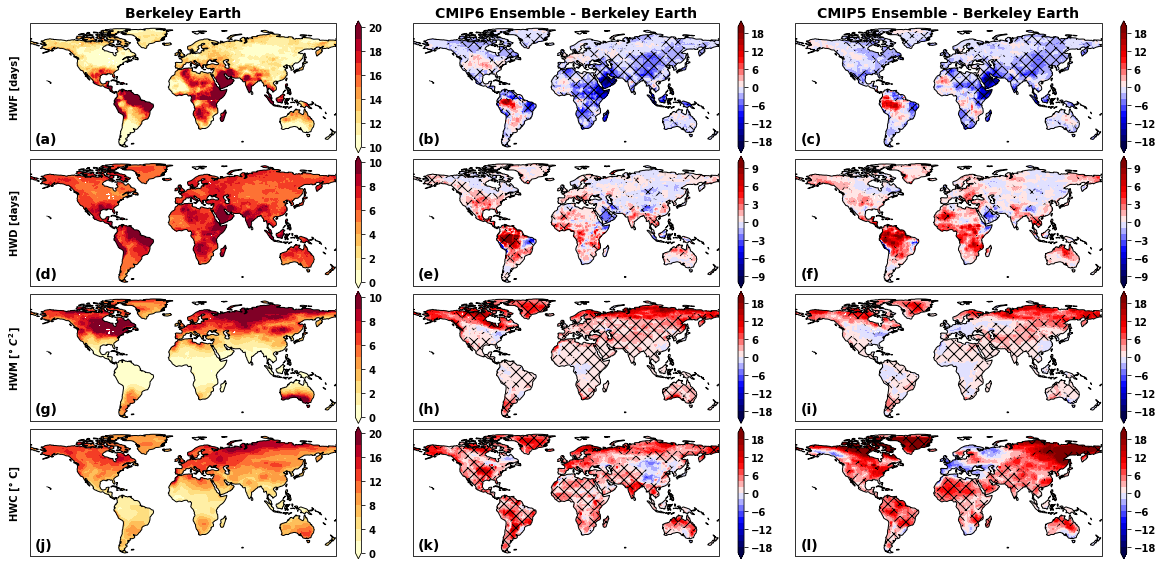

In [22]:
# Bias
rangelim = [10,10,10,10]
vlabels = ['HWF [days]','HWD [days]','HWM [\xb0 $C^{2}$]','HWC [\xb0 C]']
dummyarr = np.zeros((4,nlat,nlon),dtype=np.float64)
berkmeanma = np.ma.masked_array(BEmean,lm!=0).filled(np.nan)
ensbiasma6 = np.ma.masked_array(bias6,lm!=0).filled(np.nan)
ensbiassignma6 = np.ma.masked_array(biassign6,lm!=0).filled(np.nan)
ensbiassignma62 = np.where(ensbiassignma6<=-1,1,ensbiassignma6)
ensbiasma5 = np.ma.masked_array(bias5,lm!=0).filled(np.nan)
ensbiassignma5 = np.ma.masked_array(biassign5,lm!=0).filled(np.nan)
ensbiassignma52 = np.where(ensbiassignma5<=-1,1,ensbiassignma5)


plot_ensemble_contour(lat1d[30:],lon1d,berkmeanma[:,30:,:],dummyarr[:,30:,:],ensbiasma6[:,30:,:],ensbiassignma62[:,30:,:],ensbiasma5[:,30:,:],ensbiassignma52[:,30:,:],vlabels,omn,omx,varlim,rangelim,'contour_CMIP6andCMIP5_ensemble_bias_3x4.pdf',False)


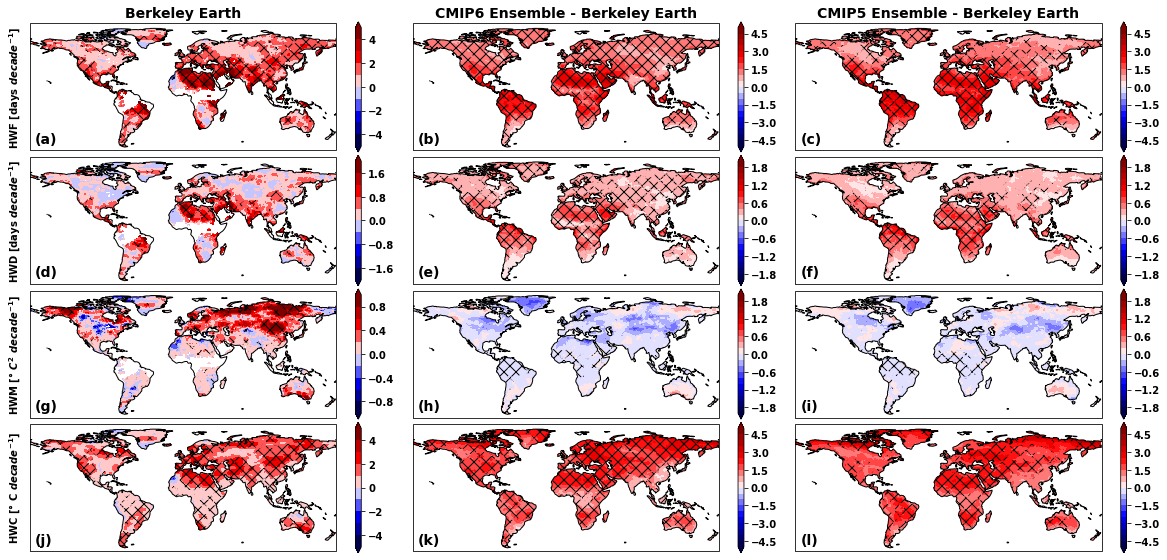

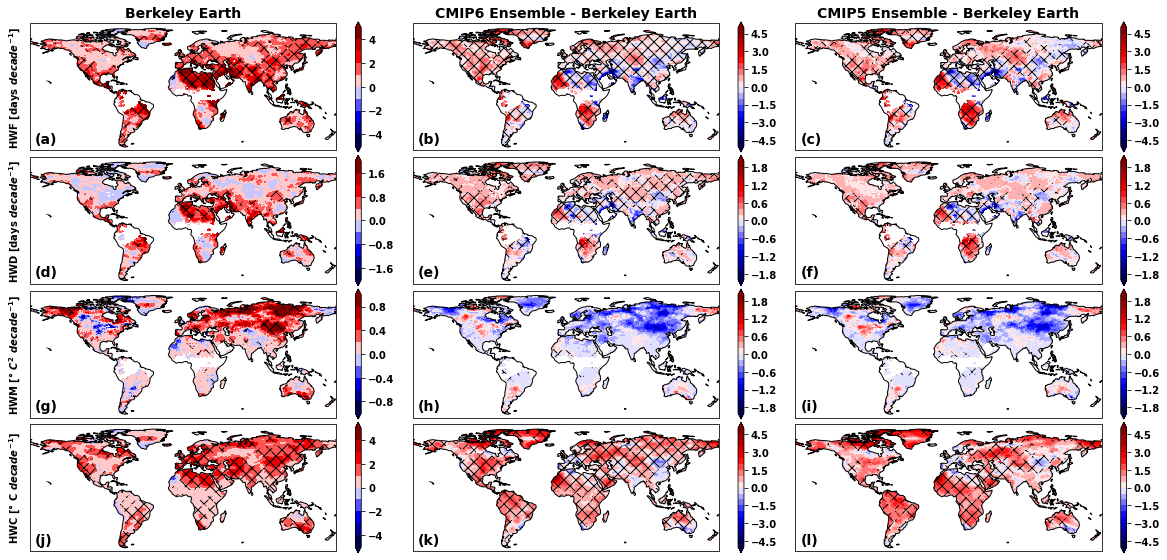

In [23]:

trendrangelim = [5,2,3,5]
vlabels = ['HWF [days $decade^{-1}$]','HWD [days $decade^{-1}$]','HWM [\xb0 $C^{2}$ $decade^{-1}$]','HWC [\xb0 C $decade^{-1}$]']

berkslopema = np.ma.masked_array(BEslope,lm!=0).filled(np.nan)
berkslopesignma = np.ma.masked_array(BEslopesig,lm!=0).filled(np.nan)

ensslopema6 = np.ma.masked_array(slope6,lm!=0).filled(np.nan)
ensslopesignma6 = np.ma.masked_array(slopesign6,lm!=0).filled(np.nan)

ensslopesignma62 = np.where(ensslopesignma6<=-1,1,ensslopesignma6)
ensslopema5 = np.ma.masked_array(slope5,lm!=0).filled(np.nan)
ensslopesignma5 = np.ma.masked_array(slopesign5,lm!=0).filled(np.nan)
ensslopesignma52 = np.where(ensslopesignma5<=-1,1,ensslopesignma5)


plot_ensemble_contour(lat1d[30:],lon1d,berkslopema[:,30:,:]*10,berkslopesignma[:,30:,:],ensslopema6[:,30:,:]*10,ensslopesignma62[:,30:,:],ensslopema5[:,30:,:]*10,ensslopesignma52[:,30:,:],vlabels,notmx,otmx,trendlim,trendrangelim,'contour_CMIP6andCMIP5_ensemble_trend_3x4.png',True)

ensslopesignma63 = np.where(BEslopesig>=0.,ensslopesignma62,np.nan)
ensslopesignma53 = np.where(BEslopesig>=0.,ensslopesignma52,np.nan)


plot_ensemble_contour(lat1d[30:],lon1d,berkslopema[:,30:,:]*10,berkslopesignma[:,30:,:],(ensslopema6[:,30:,:]*10-berkslopema[:,30:,:]*10),ensslopesignma63[:,30:,:],(ensslopema5[:,30:,:]*10-berkslopema[:,30:,:]*10),ensslopesignma53[:,30:,:],vlabels,notmx,otmx,trendlim,trendrangelim,'contour_CMIP6andCMIP5_ensemble_trend_difference_3x4.pdf',True)


##### Boxplots

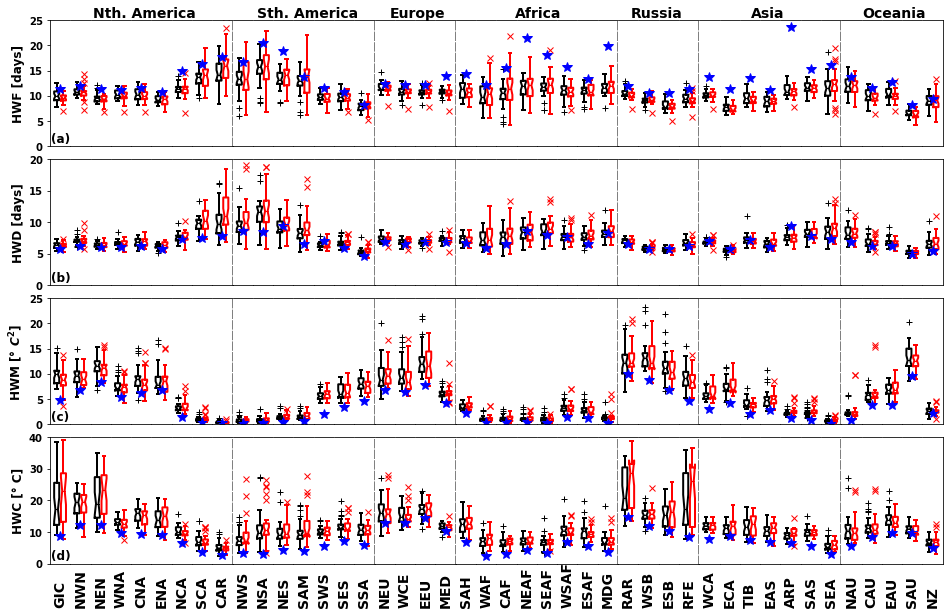

In [33]:
vlabels = ['HWF [days]','HWD [days]','HWM [\xb0 $C^{2}$]','HWC [\xb0 C]']
vmx = [25,20,25,40]
vmn = [0,0,0,0]
plot_boxplot(regBEmean[:,:-2],regmodmean6[:,:-2,:],regmodmean5[:,:-2,:],vlabels,rlabels,vmn,vmx,'boxplots_CMIP6andCMIP5_region_mean.pdf')


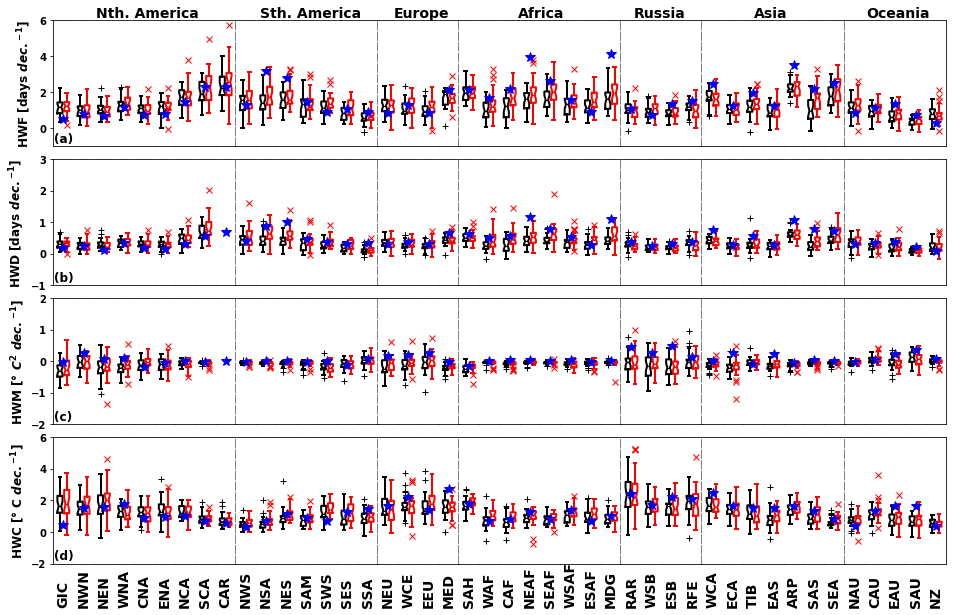

In [34]:
vlabels = ['HWF [days $dec.^{-1}$]','HWD [days $dec.^{-1}$]','HWM [\xb0 $C^{2}$ $dec.^{-1}$]','HWC [\xb0 C $dec.^{-1}$]']
vmx = [6,3,2,6]
vmn = [-1,-1,-2,-2]
plot_boxplot(regBEtrend[:,:-2]*10,regmodtrend6[:,:-2,:]*10,regmodtrend5[:,:-2,:]*10,vlabels,rlabels,vmn,vmx,'boxplots_CMIP6andCMIP5_region_trend.png')


##### Histograms

In [9]:
var = ['HWM','HWF']
nvar = len(var)
modvar = ['HWM_EHF','HWF_EHF']

nyrs = 65
#skill = np.empty((nvar,nmod),dtype=np.float64)
skill5 = np.empty((nvar,nmod),dtype=np.float64)
for eind in range(nvar):
    
    print('Calculating and plotting %s' %(var[eind]))
    
    # Read in the Berkeley Earth data - decode times necessary as HWF and HWD in units of days
    berk = xr.open_dataset('%s%s%s%s' %(berkdir,bprefix,var[eind],bendfix),decode_times=False)
    berkma = np.ma.masked_array(berk[var[eind]].values,berk[var[eind]].values<=0).filled(np.nan)
 
    # Define the common grid for the models to regrid too!
    ds_out = xr.Dataset({'lat': (['lat'], berk['latitude'].values),
             'lon': (['lon'], berk['longitude'].values),
            })

    # Define the land-sea mask (region = 0, elsewhere is nan)
    land_110 = regionmask.defined_regions.natural_earth.land_110
    land_mask = land_110.mask(ds_out)
    mask2d = ar6_land.mask(ds_out) * land_mask.squeeze(drop=True)
    
    # Define an array to stash the model data and the skill metrics

    # Now loop through the models and regrid
    moddata = np.empty((nmod,nyrs,len(berk['latitude'].values), len(berk['longitude'].values)),dtype=np.float64)
    for mind in range(nmod):
#        dm = xr.open_dataset('%s%s%s%s' %(cmip6dir,mprefix,models[mind],mendfix),decode_times=False)
        dm = xr.open_dataset('%s%s%s%s' %(cmip5dir,mprefix,models[mind],mendfix),decode_times=False)
        # If longitudes are 0 to 360 need to shift to -180 to 180
        # https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
        if np.nanmax(dm['lon']) > 200.:
            lon_name = 'lon'
            dm['_longitude_adjusted'] = xr.where(dm[lon_name] > 180,dm[lon_name] - 360,dm[lon_name])
            # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
            dm = (
                dm
                .swap_dims({lon_name: '_longitude_adjusted'})
                .sel(**{'_longitude_adjusted': sorted(dm._longitude_adjusted)})
                .drop(lon_name))
            dm = dm.rename({'_longitude_adjusted': lon_name})
            
        datavalue = dm[modvar[eind]]
        regridder = xe.Regridder(dm, ds_out, 'bilinear')
        moddata[mind,:,:,:] = regridder(datavalue)
        del dm, datavalue,regridder

   # Mask the missing values as these have not been set to nan in the files
    modma = np.ma.masked_array(moddata,moddata<=0).filled(np.nan)
            
    # Calculate the skill metrics (bias = 0, rmse = 1, spatial dsn = 2)
    for mind in range(nmod): 

#        skill[eind,mind] = cf.calc_spatialdsn(modma[mind,:,30:,:],berkma[:,30:,:],berk['latitude'].values[30:])
        skill5[eind,mind] = cf.calc_spatialdsn(modma[mind,:,30:,:],berkma[:,30:,:],berk['latitude'].values[30:])

    del berk,berkma
    del moddata,modma
    

Calculating and plotting HWM
Calculating and plotting HWF


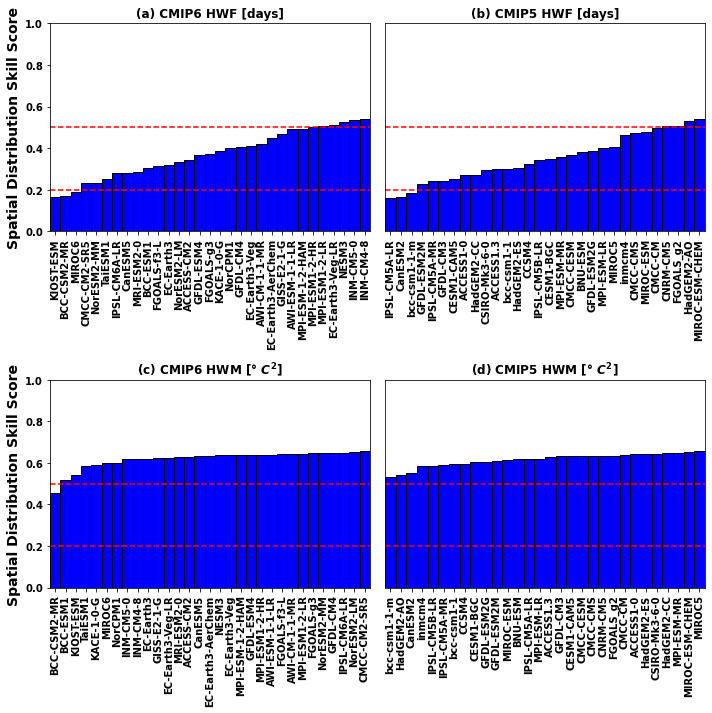

In [13]:
models6 = ['ACCESS-CM2','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1','CanESM5','CMCC-CM2-SR5',
'EC-Earth3-AerChem','EC-Earth3','EC-Earth3-Veg','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4',
'GFDL-ESM4','GISS-E2-1-G','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC6',
'MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorCPM1','NorESM2-LM','NorESM2-MM','TaiESM1']

models5 = ['ACCESS1-0','ACCESS1.3','bcc-csm1-1','bcc-csm1-1-m','BNU-ESM',
          'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CESM',
'CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0','FGOALS_g2','GFDL-CM3',
'GFDL-ESM2G','GFDL-ESM2M','HadGEM2-AO','HadGEM2-CC','HadGEM2-ES',
          'inmcm4',
'IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR','MIROC5','MIROC-ESM-CHEM',
'MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','MRI-ESM1','NorESM1-M']

vlabels = ['HWM [\xb0 $C^{2}$]','HWF [days]','HWD [days]']

plot_hist(skill,skill5,models6,models5,vlabels,"spatial_dsn_skill_score.png")

##### Skill Plots

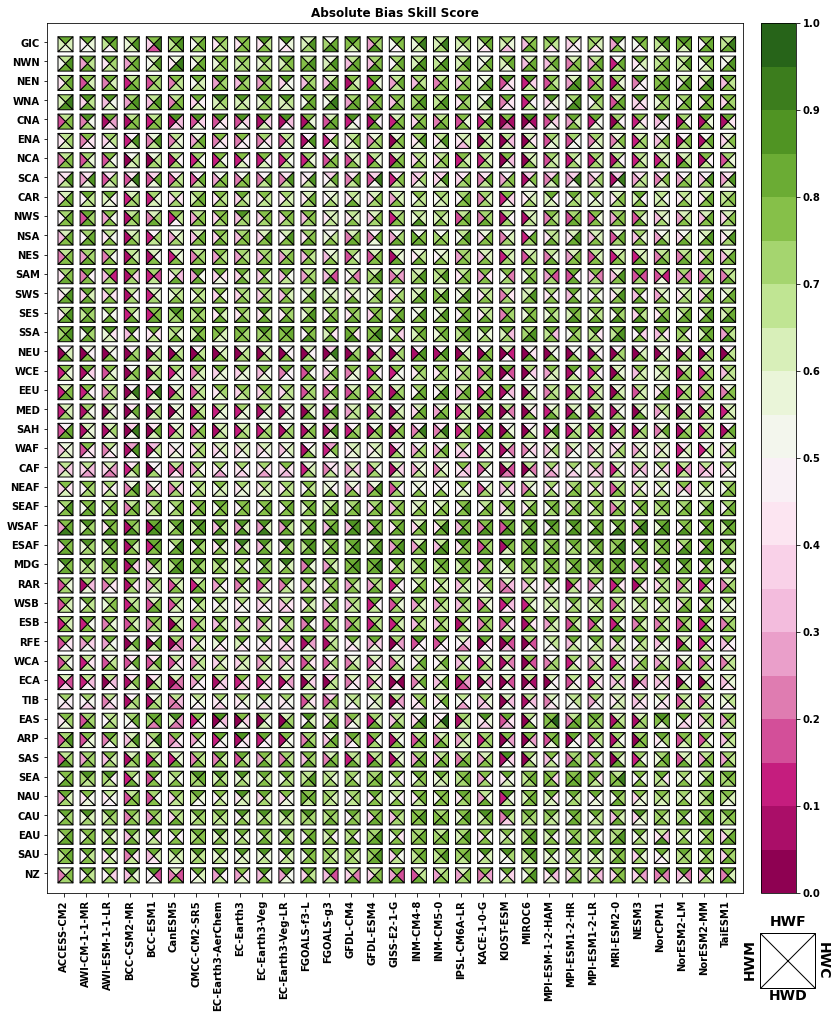

In [45]:
# CMIP6 Absolute Bias Skill Score
plot_ALLSKILL(regskill6[:,:-2,:],models6,'regional_CMIP6_absolute_bias_skill_score_all.png',rlabels,'Absolute Bias Skill Score')


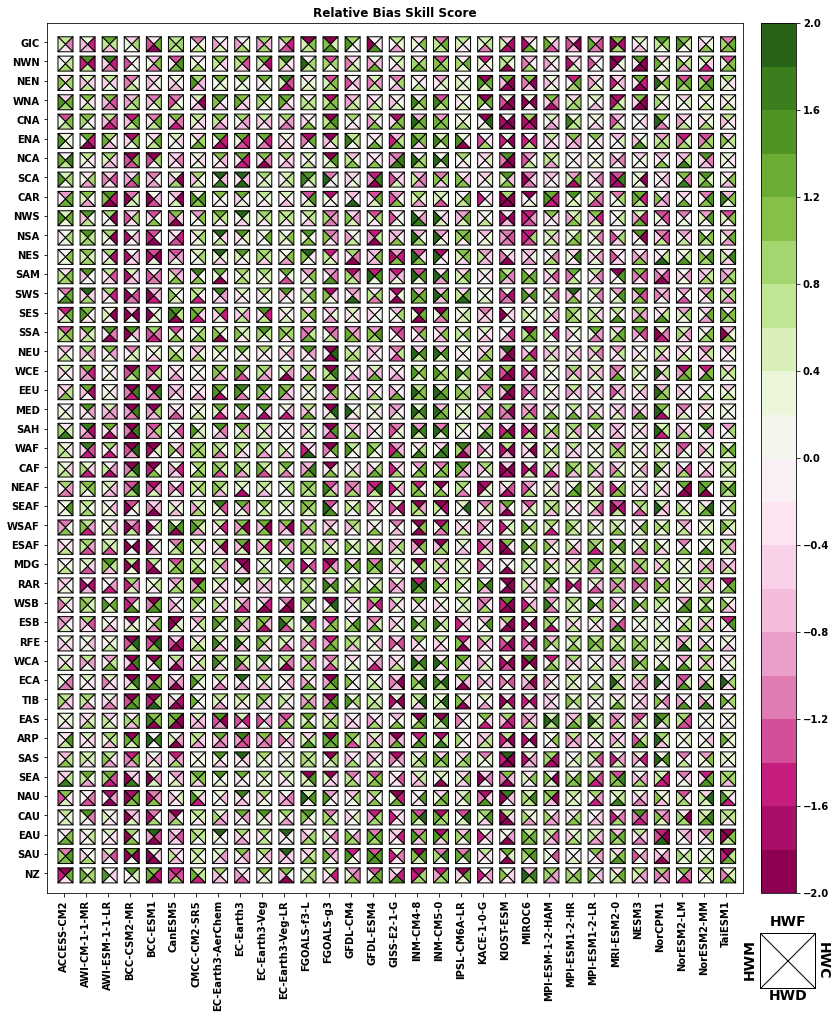

In [46]:
# CMIP6 Relative Bias Skill Score
_,nreg,nmod = regskill6.shape
# Plot the relative skill scores
relstats = np.empty((4,nreg,nmod),dtype=np.float64)
for vv in range(4):
    for rind in range(nreg):
        for mind in range(nmod):
            relstats[vv,rind,mind] = (regskill6[vv,rind,mind] - np.nanmean(regskill6[vv,rind,:],axis=0)) / np.nanstd(regskill6[vv,rind,:],axis=0)

plot_ALLSKILL(relstats[:,:-2,:],models6,'regional_CMIP6_relative_bias_skill_score_all.png',rlabels,'Relative Bias Skill Score',2.,-2.)


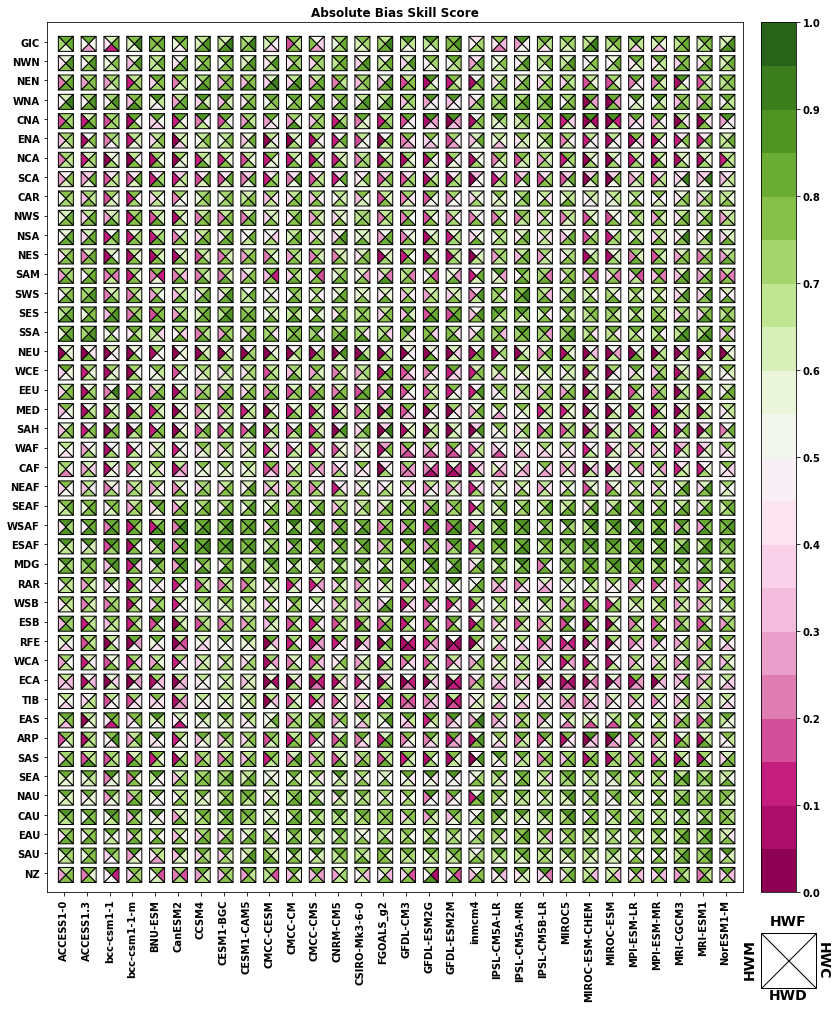

In [50]:
# CMIP5 Absolute Bias Skill Score
plot_ALLSKILL(regskill5[:,:-2,:],models5,'regional_CMIP5_absolute_bias_skill_score_all.png',rlabels,'Absolute Bias Skill Score')
